In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


In [2]:
# load validation informaiton
f= open('/data/tiny-imagenet-200/original/val/val_annotations.txt')

array=[]

for line in f.readlines():
    array.append([])
    for i in line.split():
        array[-1].append(i)

print len(array)
# print array

10000


In [4]:
# seperate val images
import os, shutil

# original_dataset_dir = '/home/dkkim/downloads/tiny-imagenet-200/original/val/images'
# train_dir = '/home/dkkim/downloads/tiny-imagenet-200/train'
# val_dir = '/home/dkkim/downloads/tiny-imagenet-200/val'

# base_dir = '/home/dkkim/downloads/tiny-imagenet-200/val'
# if not os.path.exists(base_dir):os.mkdir(base_dir)
    
#train,validation,test dir

# validation_dir=os.path.join(base_dir,'images')
# if not os.path.exists(validation_dir): os.mkdir(validation_dir)
    
# for i in range(10000):
#     dir = os.path.join(base_dir,array[i][1])
    
#     fname = array[i][0]
# #     print array[i][0],array[i][1]
#     if not os.path.exists(dir):os.mkdir(dir)
#     src=os.path.join(original_dataset_dir,fname)
#     dst=os.path.join(dir,fname)
#     shutil.copyfile(src,dst)
    

    
    


In [2]:
#pre processing

train_dir = '/data/tiny-imagenet-200/train'
val_dir = '/data/tiny-imagenet-200/val'

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20,width_shift_range =0.1,height_shift_range=0.1,shear_range=0.1,zoom_range=0.1,horizontal_flip=True,fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,target_size=(64,64),batch_size=100,class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(val_dir,target_size=(64,64),batch_size=100,class_mode='categorical')



Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


In [3]:
from keras import layers
from keras import models
from keras import regularizers
from keras.layers import Dense, merge, Concatenate, concatenate, Input, Dropout, Conv2D
from keras.layers.normalization import BatchNormalization

def resnet(input,n_ch):
    x1 = layers.convolutional.ZeroPadding2D((1,1))(input)
    x1 = Conv2D(n_ch,(3,3), kernel_initializer='he_normal')(x1)
    x1 = BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x1 = layers.convolutional.ZeroPadding2D((1,1))(x1)
    x1 = Conv2D(n_ch,(3,3), kernel_initializer='he_normal')(x1)
    x1 = BatchNormalization()(x1)
    output = concatenate(inputs = [input,x1])
    output = layers.Activation('relu')(output)
    output = Conv2D(n_ch,(1,1),kernel_initializer='he_normal')(output)
    return output

# def skip_connect(input,n_ch):
    
#     x1 = Conv2D(n_ch/2,(1,1), kernel_initializer='he_normal')(input)
#     x1 = BatchNormalization()(x1)
#     x1 = layers.Activation('relu')(x1)
#     x1 = layers.convolutional.ZeroPadding2D((1,1))(x1)
#     x1 = Conv2D(n_ch,(3,3), kernel_initializer='he_normal')(x1)
#     x1 = BatchNormalization()(x1)
#     x1 = layers.Activation('relu')(x1)
#     x1 = Conv2D(n_ch/2,(1,1), kernel_initializer='he_normal')(x1)
#     x1 = BatchNormalization()(x1)
#     x1 = layers.Activation('relu')(x1)
    
#     x2 = Conv2D(n_ch/2,(1,1), kernel_initializer='he_normal')(input)
#     x2 = BatchNormalization()(x2)
#     x2 = layers.Activation('relu')(x2)
    
#     output = concatenate(inputs = [x2,x1])
#     return output

def skip_connect(input,n_ch):

    x1 = BatchNormalization()(input)
    x1 = layers.Activation('relu')(x1)
    x1 = Conv2D(n_ch/2,(1,1), kernel_initializer='he_normal')(x1)    
    x1 = layers.convolutional.ZeroPadding2D((1,1))(x1)
    x1 = BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x1 = Conv2D(n_ch,(3,3), kernel_initializer='he_normal')(x1)
    x1 = BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x1 = Conv2D(n_ch/2,(1,1), kernel_initializer='he_normal')(x1)
    
    x2 = BatchNormalization()(input)
    x2 = layers.Activation('relu')(x2)
    x2 = Conv2D(n_ch/2,(1,1), kernel_initializer='he_normal')(x2)    
    
    output = concatenate(inputs = [x2,x1])
    return output
    

input_dat = Input(shape=(64,64,3))

first_layer = layers.convolutional.ZeroPadding2D((1,1))(input_dat)
first_layer = BatchNormalization()(first_layer)
first_layer = Conv2D(64,(3,3), kernel_initializer='he_normal')(first_layer)
# first_layer = layers.Activation('relu')(first_layer)
# first_layer = layers.MaxPooling2D((2,2))(first_layer)

x1 = skip_connect(first_layer,64)
x1 = skip_connect(x1,64)
x1 = skip_connect(x1,64)
x1 = layers.MaxPooling2D((2,2))(x1)

x2 = skip_connect(x1,128)
x2 = skip_connect(x2,128)
x2 = skip_connect(x2,128)
x2 = layers.MaxPooling2D((2,2))(x2)

x2_2 = skip_connect(x2,256)
x2_2 = skip_connect(x2_2,256)
x2_2 = skip_connect(x2_2,256)
x2_2 = layers.MaxPooling2D((2,2))(x2)

x3 = skip_connect(x2_2,512)
x3 = skip_connect(x3,512)
x3 = skip_connect(x3,512)

output =  layers.AveragePooling2D((8,8))(x3)
output = layers.Flatten()(output)
output = layers.Dense(200,kernel_regularizer=regularizers.l2(0.001),activation='softmax', kernel_initializer='he_normal')(output)
# output = layers.Dense(200,activation='relu', kernel_initializer='he_normal')(output)

model=models.Model(inputs=input_dat,outputs=output)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 66, 66, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 66, 66, 3)    12          zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   1792        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [5]:
from keras import optimizers
from keras.callbacks import ModelCheckpoint,LearningRateScheduler,Callback
import os, shutil
import math

# learning rate log
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

## learning rate decay

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop)) # lr = lr0 * drop^floor(epoch / epochs_drop)
    return lrate

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self,batch,logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))

loss_history = LossHistory()

## model compile

optimizer = optimizers.RMSprop(lr=0.001)
lr_metric = get_lr_metric(optimizer)

model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['acc',lr_metric])
lrate = LearningRateScheduler(step_decay)
# check point
log_dir='/data/tiny_3_log'
log_data_dir=os.path.join(log_dir,'log_4-3') ################ version
if not os.path.exists(log_data_dir): os.mkdir(log_data_dir)
    
filepath=os.path.join(log_data_dir,'weights.{epoch:02d}-{val_acc:.2f}.hdf5')
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint,lrate]


#training
history=model.fit_generator(train_generator,steps_per_epoch=1000,epochs=50,callbacks=callbacks_list,validation_data=validation_generator,validation_steps=50)



# model.save

model_weight=os.path.join(log_data_dir,'tiny_3_imagenet.h5')
model_arch=os.path.join(log_data_dir,'tiny_3_imagenet.json')

model.save(model_weight)
with open(model_arch,'w') as f:
    f.write(model.to_json())
    
import csv

dict = history.history

csv_path=os.path.join(log_data_dir,'tiny_3_log.csv')

w = csv.writer(open(csv_path, "w"))
for key, val in dict.items():
    w.writerow([key, val])


Epoch 1/50
1000/1000 [==============================] - 547s 547ms/step - loss: 4.5353 - acc: 0.0976 - lr: 0.0010 - val_loss: 4.8502 - val_acc: 0.0766 - val_lr: 0.0010
Epoch 2/50
1000/1000 [==============================] - 521s 521ms/step - loss: 3.6212 - acc: 0.2067 - lr: 0.0010 - val_loss: 3.7978 - val_acc: 0.1872 - val_lr: 0.0010
Epoch 3/50
1000/1000 [==============================] - 521s 521ms/step - loss: 3.2600 - acc: 0.2717 - lr: 0.0010 - val_loss: 4.3499 - val_acc: 0.1654 - val_lr: 0.0010
Epoch 4/50
1000/1000 [==============================] - 520s 520ms/step - loss: 3.0192 - acc: 0.3198 - lr: 0.0010 - val_loss: 3.4522 - val_acc: 0.2638 - val_lr: 0.0010
Epoch 5/50
1000/1000 [==============================] - 522s 522ms/step - loss: 2.8482 - acc: 0.3548 - lr: 0.0010 - val_loss: 3.7164 - val_acc: 0.2322 - val_lr: 0.0010
Epoch 6/50
1000/1000 [==============================] - 521s 521ms/step - loss: 2.7159 - acc: 0.3818 - lr: 0.0010 - val_loss: 3.4430 - val_acc: 0.2794 - val_lr:

Epoch 48/50
1000/1000 [==============================] - 520s 520ms/step - loss: 1.0059 - acc: 0.8070 - lr: 6.2500e-05 - val_loss: 3.4191 - val_acc: 0.4192 - val_lr: 6.2500e-05
Epoch 49/50
1000/1000 [==============================] - 521s 521ms/step - loss: 1.0034 - acc: 0.8076 - lr: 6.2500e-05 - val_loss: 3.2860 - val_acc: 0.4382 - val_lr: 6.2500e-05
Epoch 50/50
1000/1000 [==============================] - 521s 521ms/step - loss: 0.9708 - acc: 0.8179 - lr: 3.1250e-05 - val_loss: 3.3335 - val_acc: 0.4296 - val_lr: 3.1250e-05


In [6]:

# model.save

model_weight=os.path.join(log_data_dir,'tiny_2_imagenet.h5')
model_arch=os.path.join(log_data_dir,'tiny_2_imagenet.json')

model.save(model_weight)
with open(model_arch,'w') as f:
    f.write(model.to_json())
    
import csv

dict = history.history

csv_path=os.path.join(log_data_dir,'tiny_2_log.csv')

w = csv.writer(open(csv_path, "w"))
for key, val in dict.items():
    w.writerow([key, val])

In [28]:
for layer in model.layers:
    print (layer, '\n')
    print(layer., layer.get_weights())


(<keras.layers.convolutional.ZeroPadding2D object at 0x7f2e067a58d0>, '\n')
({'name': 'zero_padding2d_5', 'dtype': 'float32', 'trainable': True, 'data_format': 'channels_last', 'padding': ((1, 1), (1, 1)), 'batch_input_shape': (None, 64, 64, 3)}, [])
(<keras.layers.convolutional.Conv2D object at 0x7f2e296012d0>, '\n')
({'padding': 'valid', 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'distribution': 'uniform', 'scale': 1.0, 'seed': None, 'mode': 'fan_avg'}}, 'name': 'conv2d_8', 'bias_regularizer': None, 'filters': 64, 'bias_constraint': None, 'activation': 'relu', 'trainable': True, 'data_format': 'channels_last', 'kernel_constraint': None, 'strides': (1, 1), 'dilation_rate': (1, 1), 'kernel_regularizer': None, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'use_bias': True, 'activity_regularizer': None, 'kernel_size': (3, 3)}, [array([[[[ 0.07798229,  0.05787009,  0.09384591, ..., -0.07573827,
           0.00620476,  0.03488709],
         [ 0.09162841

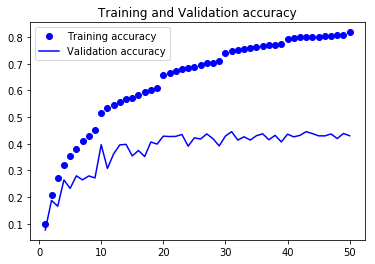

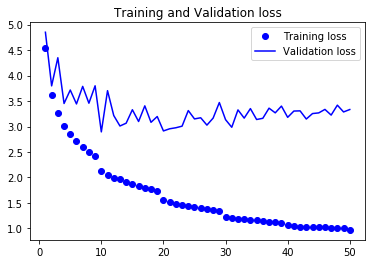

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc,'bo',label = 'Training accuracy')
plt.plot(epochs, val_acc,'b',label = 'Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

# with open('/home/dkkim/documents/tiny_log_2.txt','w') as output:
#     output.write(str(history.history))
    



In [84]:
from keras import backend as K 

# Do some code, e.g. train and save model

K.clear_session()

#del model

<function matplotlib.pyplot.show>

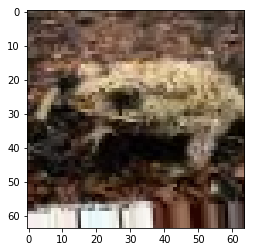

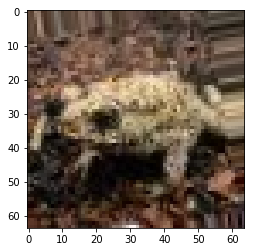

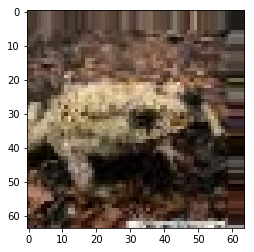

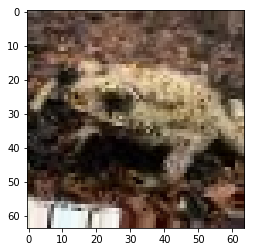

In [7]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import os, shutil

# path_check='/data/tiny-imagenet-200/train/n01644900/images'
# fnames = sorted([os.path.join(path_check, fname) for fname in os.listdir(path_check)])


# img_path = fnames[9]

# img = image.load_img(img_path, target_size=(64,64))

# x = image.img_to_array(img)
# x = x.reshape((1,) + x.shape)

# datagen = ImageDataGenerator(rotation_range=10,width_shift_range =0.1,height_shift_range=0.1,shear_range=0.1,zoom_range=0.1,horizontal_flip=True,fill_mode='nearest')

# j=0
# for batch in datagen.flow(x, batch_size =1):
#     plt.figure(j)
#     imgplot = plt.imshow(image.array_to_img(batch[0]))
#     j += 1
#     if j%4 ==0:
#         break
        
# plt.show